In [59]:
library(MMWRweek)
library(ggplot2)
library(lubridate)
library(dplyr)
library(tidyr)
library(zoo)

find_median = function(values, dates, train_before="2019-10-01") {
    idx = dates < train_before
    state_deaths = data.frame(weeks=MMWRweek(data$WeekDate)$MMWRweek, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(med = median(values, na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$med[order(merged$dates)]
}
find_quantile = function(values, dates, q = .95, train_before="2019-10-01", before_month=6) {
    idx = dates < train_before
    state_deaths = data.frame(weeks=MMWRweek(data$WeekDate)$MMWRweek, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(est = quantile(values, probs=c(q), na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$est[order(merged$dates)]
}
find_sd = function(values, dates, train_before="2019-10-01", before_month=6) {
    idx = dates < train_before
    state_deaths = data.frame(weeks=MMWRweek(data$WeekDate)$MMWRweek, values=values, dates=dates)
    std = state_deaths[idx,] %>% group_by(weeks) %>% summarise(std = sd(values, na.rm=TRUE) / sqrt(length(values)))
    merged = merge(state_deaths, std, by="weeks")
    merged$std[order(merged$dates)]
}
# set path as needed

#setwd("~/RawData/OutFiles")

# Trends calculated in 2 ways:
# 1. Median quantiles
# 2. Quantile regression with week as predictor and splines as smoothers



data = read.csv("~/animal_mortality/RawData/influenza.csv", sep=";")
# data$Week <- sprintf("W%02d", data$Week)

data = data %>% separate(Week, c('Year', 'Week'), sep=4)

data$Week <- sprintf("W%02d", as.numeric(data$Week))
data$Count = data$Total.ILI

data$WeekYear <- c(paste(data$Year,data$Week,"1",sep="-"))
data$WeekDate = ISOweek::ISOweek2date((data$WeekYear))
data = data[year(data$WeekDate) > 2013,]
head(data)

,Year,Week,Total.ILI,Total.Patients,X..Unweighted.ILI,X.Weighted.ILI,Count,WeekYear,WeekDate
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<date>
693,2014,W02,28149,811947,"3,467","3,572",28149,2014-W02-1,2014-01-06
694,2014,W03,28614,859797,"3,328","3,368",28614,2014-W03-1,2014-01-13
695,2014,W04,25477,785885,"3,242","3,398",25477,2014-W04-1,2014-01-20
696,2014,W05,23481,817326,"2,873","3,118",23481,2014-W05-1,2014-01-27
697,2014,W06,21198,813543,"2,606","2,813",21198,2014-W06-1,2014-02-03
698,2014,W07,18211,778029,"2,341","2,485",18211,2014-W07-1,2014-02-10


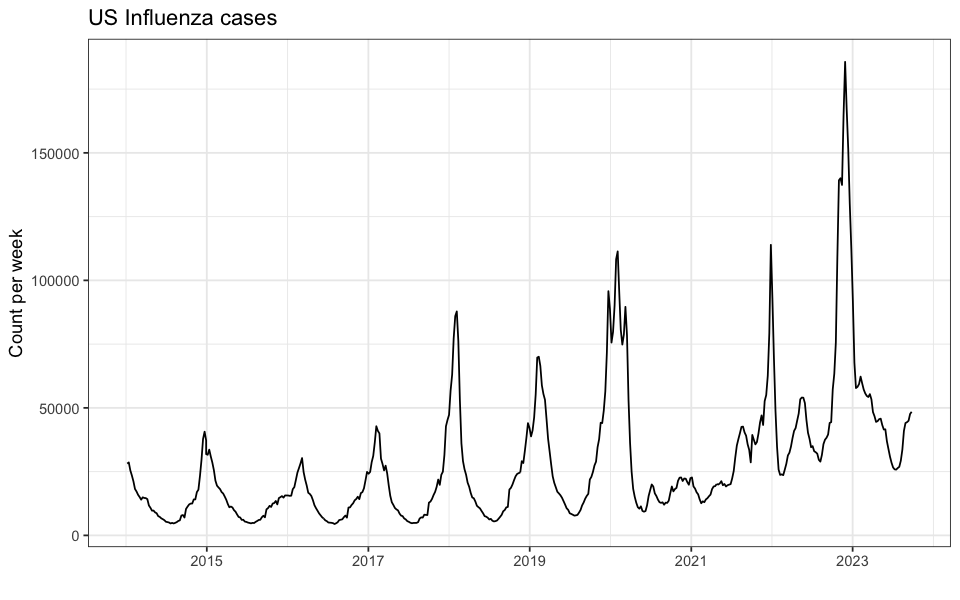

In [60]:
theme_set(theme_bw())
ggplot(data)+
  geom_line(aes(x=WeekDate,y=Count))+
scale_x_date(#limits = c(as.Date("2019-01-01"), NA),
    date_breaks = '2 year', date_labels = '%Y')+
  labs(title = 'US Influenza cases',
       #subtitle ='',
       #caption = '',
       x = '', y="Count per week")

In [61]:
data = data %>% mutate(ma=rollapply(log(Count, base = exp(1)),6,mean,align='center',fill=NA))

data_centered = data %>% reframe(
    ma = ma,
    Count=Count,
    logcount = log(Count),
    median = find_median(ma, WeekDate),
    std = find_sd(ma, WeekDate),
    upper = find_quantile(ma, WeekDate, q=0.975),
    lower = find_quantile(ma, WeekDate, q=0.025),
    WeekDate = WeekDate)
data_centered$centered = exp(data_centered$ma - data_centered$median) - 1
data_centered$centered_high = exp(data_centered$ma - (data_centered$lower)) - 1
data_centered$centered_low = exp(data_centered$ma - (data_centered$upper)) - 1
head(data_centered)

,ma,Count,logcount,median,std,upper,lower,WeekDate,centered,centered_high,centered_low
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
1,NA,28149,10.245267,10.31719,0.2015197,10.98484,9.765091,2014-01-06,NA,NA,NA
2,NA,28614,10.261651,10.33244,0.2126134,11.09196,9.815105,2014-01-13,NA,NA,NA
3,10.081307,25477,10.145531,10.29567,0.2100026,11.16343,9.872050,2014-01-20,-0.1929455,0.23276116,-0.6611245
4,9.999284,23481,10.063947,10.28666,0.2177115,11.16470,9.939375,2014-01-27,-0.2497720,0.06174006,-0.6882085
5,9.901574,21198,9.961662,10.26865,0.2183861,11.09068,9.911992,2014-02-03,-0.3072436,-0.01036332,-0.6955069
6,9.813686,18211,9.809781,10.30268,0.2147027,11.02723,9.824263,2014-02-10,-0.3867554,-0.01052134,-0.7028589


Warning message:
“Removed 3 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_line()`).”


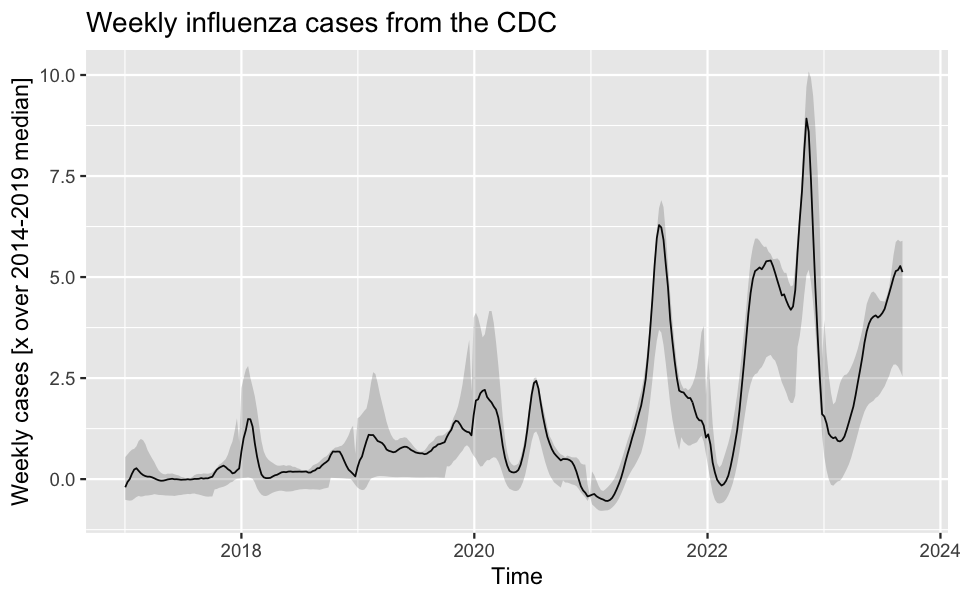

In [62]:
options(repr.plot.width=8, repr.plot.height=5)
b = ggplot(data_centered[year(data_centered$WeekDate) > 2016,], aes(x=WeekDate, y=centered)) + geom_line() +
 geom_ribbon(aes(ymin=centered_low, ymax=centered_high), alpha = 0.2) +
 labs(x = "Time", y = "Weekly cases [x over 2014-2019 median]", title="Weekly influenza cases from the CDC") + 
theme_gray(base_size = 14) 
b
ggsave("excessCDC.png", width=8, height=5)